In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk

from sklearn import feature_selection, feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics

import gensim
import gensim.downloader as gensim_api

In [2]:
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [3]:
df = pd.read_csv('./JEOPARDY_CSV.csv')
df.drop (['Show Number', ' Air Date', ' Round', ' Value', ' Answer'], axis=1, inplace=True)

In [4]:
keywords = {
    'MUSIC': ['MUSIC', 'SONG'],
    'GEOGRAPHY': ['GEOGRAPHY'],
    'HISTORY': ['HISTOR', 'CENTURY'],
    'SCIENCE': ['BIOLOGY', 'PHYSIC', 'CHEMISTRY', 'INVENTION'],
    'GOVERNMENT': ['GOVERN', 'POLITIC', 'STATE']
}

In [5]:
df = df.rename(columns={' Category':'Category'})

In [6]:
# for index, row in df.iterrows():
#     print(type(row['Category']))

In [7]:
new_cats = list(keywords.keys())
print(new_cats)
rows_containing_relevant_questions = []
new_cat_list = []

for index, row in df.iterrows():
    for key in new_cats:
        for item in keywords[key]:
            # if row['Category'].contains(item):
            if item in row['Category']:
                rows_containing_relevant_questions.append(row)
                new_cat_list.append(key)

['MUSIC', 'GEOGRAPHY', 'HISTORY', 'SCIENCE', 'GOVERNMENT']


In [8]:
ndf = pd.DataFrame(rows_containing_relevant_questions)
ndf["New_Category"] = new_cat_list
ndf


,Category,Question,New_Category
0,HISTORY,"For the last 8 years of his life, Galileo was ...",HISTORY
6,HISTORY,Built in 312 B.C. to link Rome & the South of ...,HISTORY
12,HISTORY,In 1000 Rajaraja I of the Cholas battled to ta...,HISTORY
18,HISTORY,Karl led the first of these Marxist organizati...,HISTORY
24,HISTORY,This Asian political party was founded in 1885...,HISTORY
...,...,...,...
216876,LOVE SONGS IN GERMAN,"The Partridge Family: ""Ich Denke Ich Liebe Dich""",MUSIC
216882,LOVE SONGS IN GERMAN,"The Captain & Tennille: ""Liebe Halt Uns Zusammen""",MUSIC
216888,LOVE SONGS IN GERMAN,"Stevie Wonder: ""Sie Sind Der Sonnenschein Mein...",MUSIC
216894,LOVE SONGS IN GERMAN,"Joe Cocker: ""Sie Sind So Schon""",MUSIC


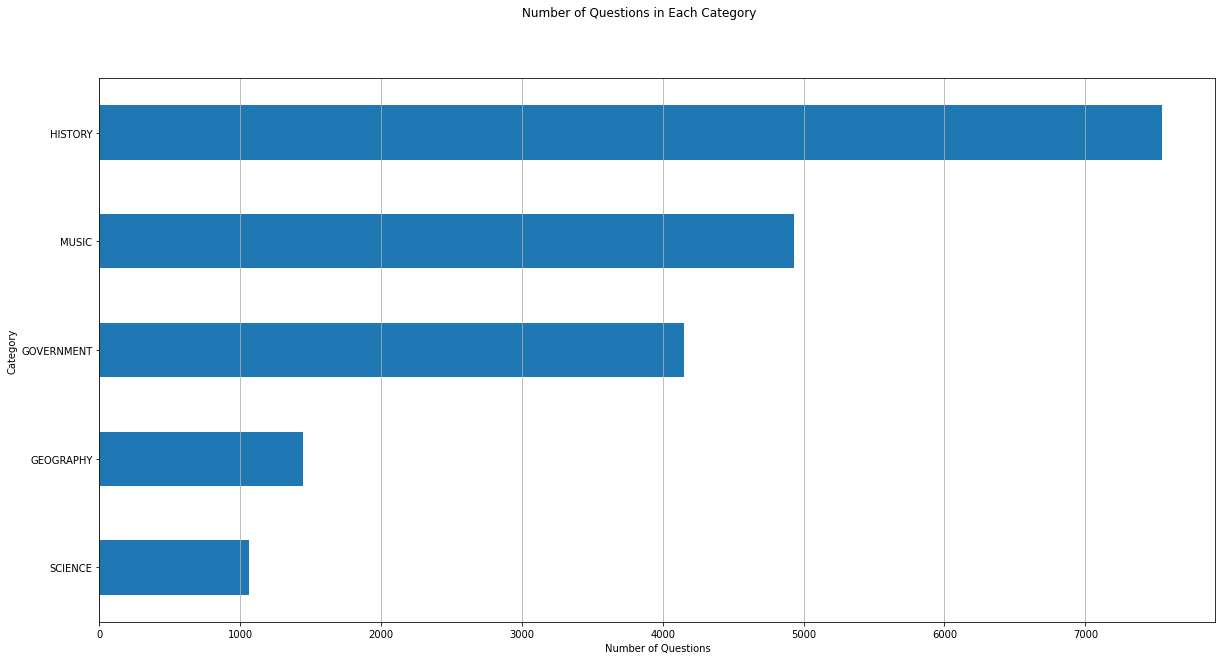

In [9]:
fig, ax = plt.subplots()
fig.suptitle("Number of Questions in Each Category", fontsize=12)
ndf["New_Category"].reset_index().groupby("New_Category").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.xlabel("Number of Questions")
plt.ylabel("Category")
plt.show()

## Preprocessing

In [10]:
def preprocessing_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):

    ## cleaning
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'[0-9]+', '', text)

    ## tokenizing
    lst_text = text.split()

    ## remove stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    
    ## Stemming
    if flg_stemm == True:
        ps = nltk.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    
    ## Lemmatisation
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    
    ## Converting list back to string
    text = " ".join(lst_text)
    
    return text

In [11]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ujwal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
ndf["Text_Clean"] = ndf[" Question"].apply(
    lambda x: preprocessing_text(x, True, True, lst_stopwords=lst_stopwords)
)

ndf

,Category,Question,New_Category,Text_Clean
0,HISTORY,"For the last 8 years of his life, Galileo was ...",HISTORY,last year life galileo hous arrest espous man ...
6,HISTORY,Built in 312 B.C. to link Rome & the South of ...,HISTORY,built bc link rome south itali still use today
12,HISTORY,In 1000 Rajaraja I of the Cholas battled to ta...,HISTORY,rajaraja chola battl take indian ocean island ...
18,HISTORY,Karl led the first of these Marxist organizati...,HISTORY,karl led first marxist organiz effort second o...
24,HISTORY,This Asian political party was founded in 1885...,HISTORY,asian polit parti found indian nation part name
...,...,...,...,...
216876,LOVE SONGS IN GERMAN,"The Partridge Family: ""Ich Denke Ich Liebe Dich""",MUSIC,partridg famili ich denk ich lieb dich
216882,LOVE SONGS IN GERMAN,"The Captain & Tennille: ""Liebe Halt Uns Zusammen""",MUSIC,captain tennil lieb halt un zusammen
216888,LOVE SONGS IN GERMAN,"Stevie Wonder: ""Sie Sind Der Sonnenschein Mein...",MUSIC,stevi wonder sie sind der sonnenschein mein leben
216894,LOVE SONGS IN GERMAN,"Joe Cocker: ""Sie Sind So Schon""",MUSIC,joe cocker sie sind schon


In [14]:
ndf_train, ndf_test = model_selection.train_test_split(ndf, test_size=0.3)

y_train = ndf_train['New_Category'].values
y_test = ndf_test['New_Category'].values

In [15]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [16]:
corpus = ndf_train["Text_Clean"]

vectorizer.fit(corpus)  
x_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

Text(0.5, 1.0, 'Sparse Matrix Sample')

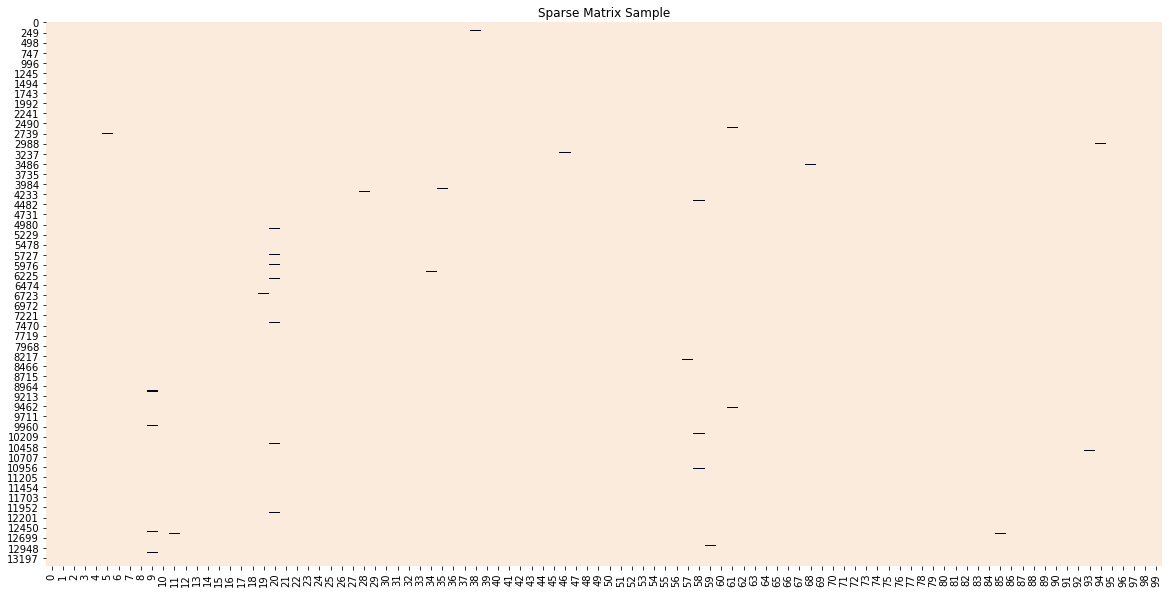

In [17]:
import numpy as np
sns.heatmap(x_train.todense()[:,np.random.randint(0,x_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [18]:
# y = ndf_train["Category"]
# X_names = vectorizer.get_feature_names()
# p_value_limit = 0.95

# ndf_features = pd.DataFrame()
# for cat in np.unique(y):
#     chi2, p = feature_selection.chi2(x_train, y==cat)
#     ndf_features = ndf_features.append(pd.DataFrame(
#                    {"feature":X_names, "score":1-p, "Category":cat}))
#     ndf_features = ndf_features.sort_values(["Category","score"], 
#                     ascending=[True,False])
#     ndf_features = ndf_features[ndf_features["score"]>p_value_limit]
    
# X_names = ndf_features["feature"].unique().tolist()

In [19]:
# for cat in np.unique(y):
#    print("# {}:".format(cat))
#    print("  . selected features:",
#          len(ndf_features[ndf_features["Category"]==cat]))
#    print("  . top features:", ",".join(
# ndf_features[ndf_features["Category"]==cat]["feature"].values[:10]))
#    print(" ")

In [20]:
# vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)

# vectorizer.fit(corpus)
# x_train = vectorizer.transform(corpus)
# dic_vocabulary = vectorizer.vocabulary_

In [21]:
# sns.heatmap(x_train.todense()[:,np.random.randint(0,x_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [22]:
classifier = naive_bayes.MultinomialNB()

In [23]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])

## train classifier
model["classifier"].fit(x_train, y_train)

## test
X_test = ndf_test["Text_Clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

Accuracy: 0.7
Auc: 0.92
Detail:
              precision    recall  f1-score   support

   GEOGRAPHY       0.88      0.26      0.41       435
  GOVERNMENT       0.77      0.49      0.60      1208
     HISTORY       0.62      0.91      0.74      2231
       MUSIC       0.84      0.80      0.82      1537
     SCIENCE       0.95      0.17      0.28       332

    accuracy                           0.70      5743
   macro avg       0.81      0.53      0.57      5743
weighted avg       0.75      0.70      0.68      5743



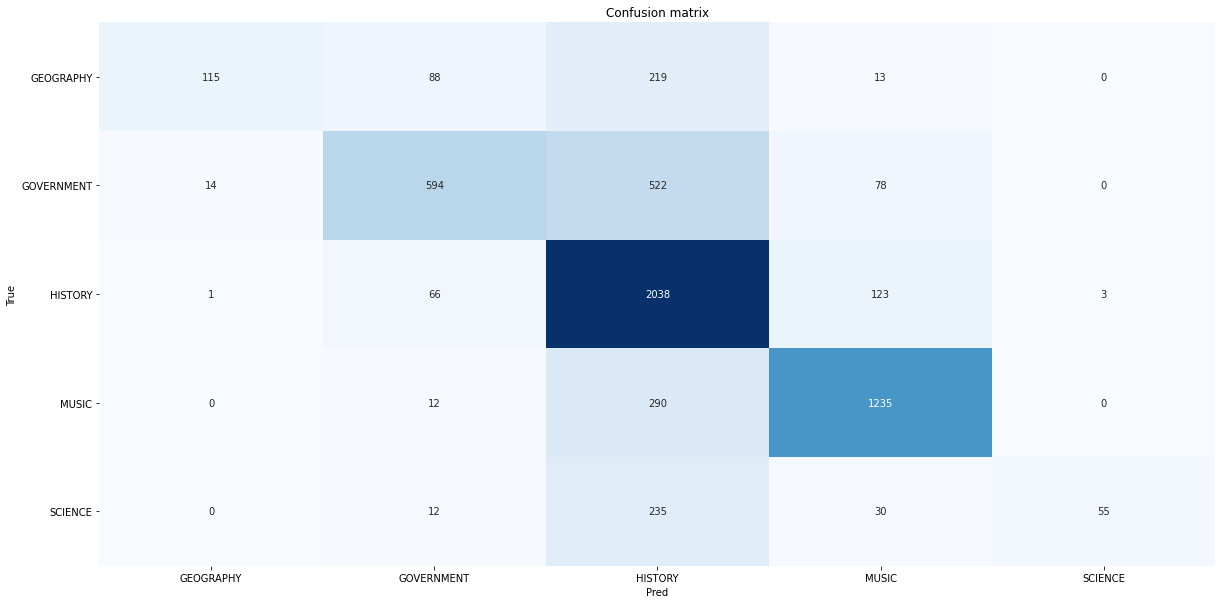

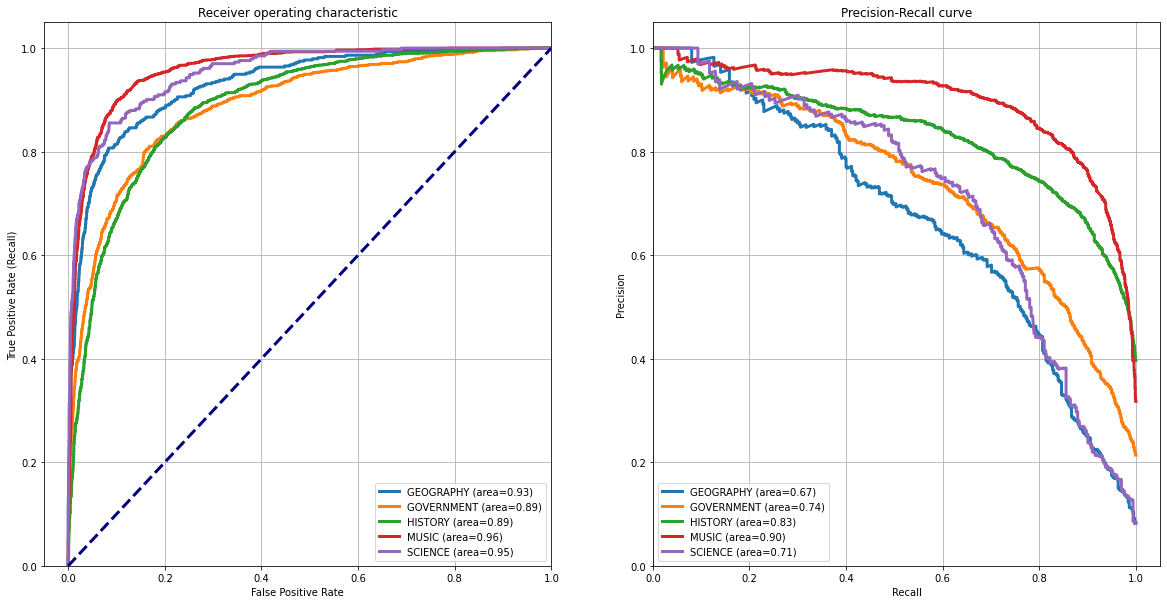

In [24]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()